In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'acne-dataset-in-yolov8-format:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4395695%2F7547567%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240325%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240325T093532Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44ed4be957bce15431b25dbe83f824159cc2aa0494a288edb95e7e33219317d434f2185fcf66e3c3ffa744e1c5decfbabe8aa1aa946b409979fbd5d635fac79def763efc770b5d55fe06a70d33ac2b1830cc7c90538cba2448c914cd53521e1f6d086f9a97e072824917f8faf35fbadf57281da7dae402467fcff73c6c315ec0e12b9fcf75e6aa8fc40ba8f9253ece1d39fb6ab7f7f0726843150c147897d31fe3fd2c182dffadc6ddd485bba97ef7ea77f0432b6061a77809db145a6e4ded947574ce6e6d9d6296584f0b63deec1674be635cb4965e70f6fedafde8d8e5052ed3168ac89610b46009f843b06b0ba8d6a77fe15aaa0a4c2116baec1015319fce'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 35503241 bytes downloaded
Downloaded and uncompressed: acne-dataset-in-yolov8-format
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, _ in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/acne-dataset-in-yolov8-format
/kaggle/input/acne-dataset-in-yolov8-format/data-2
/kaggle/input/acne-dataset-in-yolov8-format/data-2/valid
/kaggle/input/acne-dataset-in-yolov8-format/data-2/valid/images
/kaggle/input/acne-dataset-in-yolov8-format/data-2/valid/labels
/kaggle/input/acne-dataset-in-yolov8-format/data-2/test
/kaggle/input/acne-dataset-in-yolov8-format/data-2/test/images
/kaggle/input/acne-dataset-in-yolov8-format/data-2/test/labels
/kaggle/input/acne-dataset-in-yolov8-format/data-2/train
/kaggle/input/acne-dataset-in-yolov8-format/data-2/train/images
/kaggle/input/acne-dataset-in-yolov8-format/data-2/train/labels


In [3]:
!pip install ultralytics

In [4]:
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

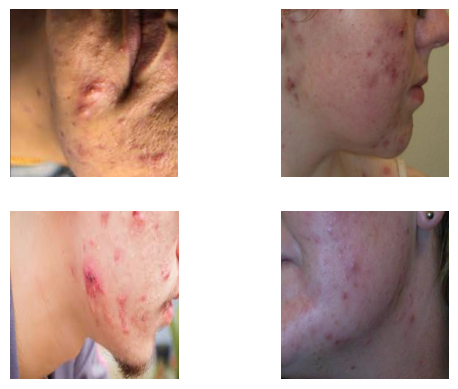

In [5]:
dataset_path = "/kaggle/input/acne-dataset-in-yolov8-format/data-2"
plot_rows, plot_cols = 2, 2
_, ax = plt.subplots(plot_rows, plot_cols)

for dir_path, _, img_file_names in os.walk(os.path.join(dataset_path, "train", "images")):
  for i, img_file_name in enumerate(img_file_names):
    if i >= plot_rows * plot_cols:
      break
    img_path = os.path.join(dir_path, img_file_name)
    img = Image.open(img_path)
    width, height = img.size

    row = i // plot_cols
    col = i % plot_cols

    ax[row][col].imshow(img)
    ax[row][col].axis("off")

plt.show()


In [6]:
dataset_info = \
"""path: /kaggle/input/acne-dataset-in-yolov8-format/data-2
train: train/images
val: valid/images
test: test/images

names:
  0: acne
"""

with open("acne.yaml", "w") as f:
  f.write(dataset_info)

In [7]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
_ = model.train(data='acne.yaml', epochs=20, imgsz=640)

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=acne.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

train: Scanning /kaggle/input/acne-dataset-in-yolov8-format/data-2/train/labels... 823 images, 12 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<00:00, 1368.70it/s]

train: New cache created: /kaggle/input/acne-dataset-in-yolov8-format/data-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/acne-dataset-in-yolov8-format/data-2/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 486.95it/s]

val: New cache created: /kaggle/input/acne-dataset-in-yolov8-format/data-2/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.6G      2.278      2.463       1.48        118        640: 100%|██████████| 52/52 [00:24<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         56        643      0.588      0.175      0.323      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.032      1.796       1.35         97        640: 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         56        643      0.401      0.392      0.349      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.75G      2.012      1.726      1.344        178        640: 100%|██████████| 52/52 [00:17<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         56        643      0.401      0.484      0.399       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.89G      1.985      1.674      1.325         65        640: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         56        643      0.439      0.501      0.437      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.98G      1.989       1.64      1.313        135        640: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         56        643      0.446      0.432        0.4      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.75G      1.952      1.623      1.308        138        640: 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         56        643      0.483      0.525      0.499      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.61G       1.93      1.596      1.298         87        640: 100%|██████████| 52/52 [00:17<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         56        643      0.493      0.561      0.521      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.84G      1.887      1.578      1.285         52        640: 100%|██████████| 52/52 [00:17<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         56        643      0.556      0.519      0.522      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.65G      1.886       1.55      1.271         89        640: 100%|██████████| 52/52 [00:16<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         56        643      0.462      0.491       0.48       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.72G      1.874      1.527      1.283        104        640: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         56        643      0.506      0.548      0.543      0.243


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.85G       1.83      1.537      1.292         73        640: 100%|██████████| 52/52 [00:20<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         56        643      0.547      0.602      0.591      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.64G      1.824      1.491      1.308         40        640: 100%|██████████| 52/52 [00:15<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         56        643      0.588      0.532      0.558      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.44G       1.82      1.463      1.297         62        640: 100%|██████████| 52/52 [00:15<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         56        643      0.575      0.611      0.596      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.67G      1.804      1.451      1.286         72        640: 100%|██████████| 52/52 [00:15<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         56        643      0.569      0.555      0.555      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.53G      1.773      1.415      1.272         79        640: 100%|██████████| 52/52 [00:16<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         56        643      0.554      0.617       0.58      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.52G      1.781      1.412      1.284        132        640: 100%|██████████| 52/52 [00:16<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         56        643      0.617      0.572      0.598      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.57G      1.778      1.417      1.269         67        640: 100%|██████████| 52/52 [00:15<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         56        643      0.616       0.56      0.579      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.44G      1.757      1.379       1.26         85        640: 100%|██████████| 52/52 [00:15<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         56        643      0.655      0.594      0.629      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.39G       1.74      1.347      1.265         82        640: 100%|██████████| 52/52 [00:16<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         56        643      0.588      0.582      0.589      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.4G       1.73      1.344       1.26         54        640: 100%|██████████| 52/52 [00:15<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         56        643      0.608       0.58      0.609      0.284



20 epochs completed in 0.107 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


                   all         56        643      0.655      0.594      0.629      0.288
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train3


In [8]:
prediction = model("https://upload.wikimedia.org/wikipedia/commons/f/f0/Acne_vulgaris_on_a_very_oily_skin.jpg")


Found https://upload.wikimedia.org/wikipedia/commons/f/f0/Acne_vulgaris_on_a_very_oily_skin.jpg locally at Acne_vulgaris_on_a_very_oily_skin.jpg
image 1/1 /content/Acne_vulgaris_on_a_very_oily_skin.jpg: 480x640 14 acnes, 61.5ms
Speed: 2.7ms preprocess, 61.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


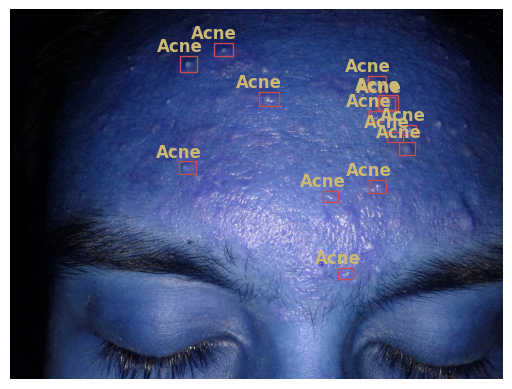

In [9]:
img = prediction[0].orig_img
_, ax = plt.subplots()

ax.imshow(img.astype(np.uint8))
ax.axis("off")

for (x, y, w, h), id in zip(prediction[0].boxes.xywh.cpu(), prediction[0].boxes.cls.cpu()):
    left = x - w / 2
    top = y - h / 2
    rect = patches.Rectangle((left, top), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.annotate("Acne", (left, top - 50), color='y', weight='bold', fontsize=12, ha='center', va='center')

plt.show()